In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs

In [2]:
np.random.seed(42)

In [3]:
grid_size = 130  # Grid size (130x130 nodes)
cell_size = 25   # 25m x 25m cells
x = np.arange(0, grid_size * cell_size, cell_size)
y = np.arange(0, grid_size * cell_size, cell_size)
xx, yy = np.meshgrid(x, y)

In [4]:
facies_proportions = {"Coarse Sand": 0.13, "Medium Sand": 0.39, "Shale": 0.48}
variogram_models = {
    "Coarse Sand": gs.Exponential(dim=2, var=1.0, len_scale=[700, 400], angles=np.pi/6),
    "Medium Sand": gs.Exponential(dim=2, var=1.0, len_scale=[500, 350], angles=np.pi/6),
    "Shale": gs.Exponential(dim=2, var=1.0, len_scale=[900, 650], angles=np.pi/6),
}


In [5]:
num_wells = 15
well_locations = np.random.randint(0, grid_size, size=(num_wells, 2))
well_facies = np.random.choice(
    list(facies_proportions.keys()),
    size=num_wells,
    p=list(facies_proportions.values())
)


In [6]:
acoustic_impedance = (
    12000 + 2000 * np.random.randn(grid_size, grid_size)
)  # Shale higher impedance, sands lower
facies_lvm = {
    "Coarse Sand": (acoustic_impedance - 13000) / 4000,
    "Medium Sand": (15000 - acoustic_impedance) / 6000,
    "Shale": (acoustic_impedance - 12000) / 3000,
}

In [7]:
for facies in facies_lvm:
    facies_lvm[facies] = np.clip(facies_lvm[facies], 0, 1)
    facies_lvm[facies] /= facies_lvm[facies].sum(axis=0)


In [10]:
simulated_facies = np.full((grid_size, grid_size), np.nan, dtype=object)

In [11]:
well_indicators = {
    facies: np.array([1 if f == facies else 0 for f in well_facies]) for facies in facies_proportions
}

In [14]:
random_path = np.random.permutation(grid_size * grid_size)
for node in random_path:
    i, j = np.unravel_index(node, (grid_size, grid_size))

   
    well_idx = np.where((well_locations == (i, j)).all(axis=1))[0]
    if well_idx.size > 0:
        simulated_facies[i, j] = well_facies[well_idx[0]]
        continue

   
    conditional_probs = {facies: facies_lvm[facies][i, j] for facies in facies_proportions}

    
    total_prob = sum(conditional_probs.values())
    if total_prob > 0:  # Ensure there are non-zero probabilities
        conditional_probs = {facies: prob / total_prob for facies, prob in conditional_probs.items()}
    else:
      
        conditional_probs = {facies: 1 / len(facies_proportions) for facies in facies_proportions}

    
    simulated_facies[i, j] = np.random.choice(
        list(conditional_probs.keys()),
        p=list(conditional_probs.values())
    )

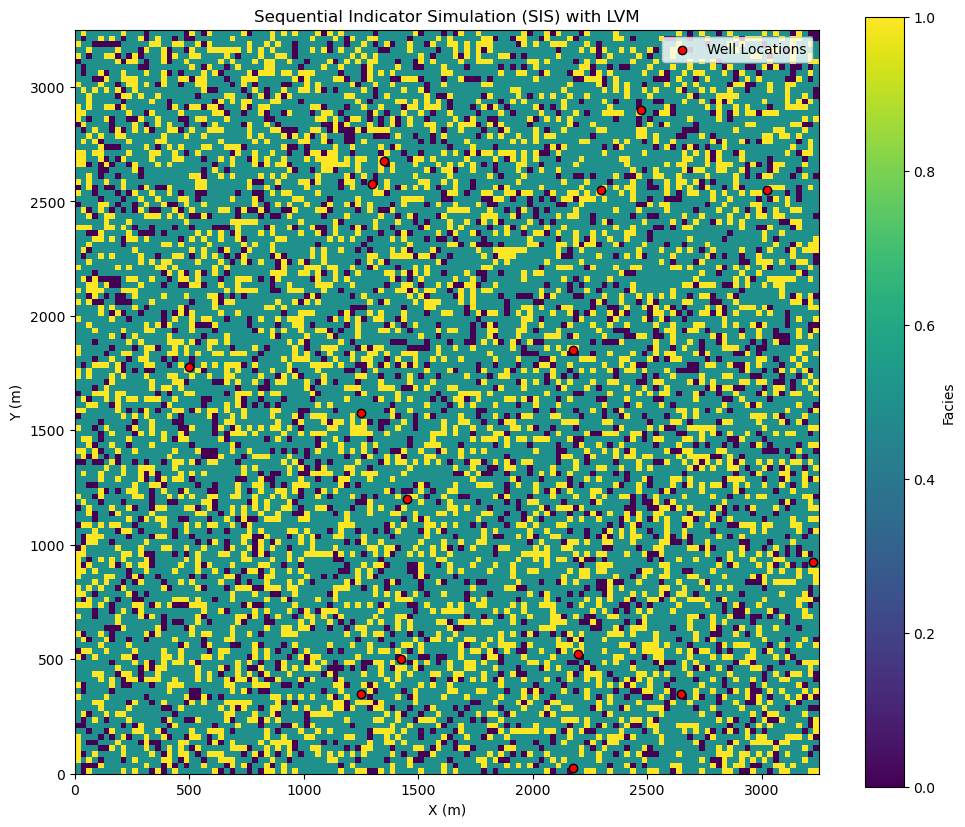

In [15]:
plt.figure(figsize=(12, 10))
plt.imshow(
    np.vectorize(lambda f: list(facies_proportions.keys()).index(f))(simulated_facies),
    extent=[0, grid_size * cell_size, 0, grid_size * cell_size],
    origin="lower",
    cmap="viridis",
)
plt.scatter(
    well_locations[:, 1] * cell_size,
    well_locations[:, 0] * cell_size,
    c="red",
    edgecolors="black",
    label="Well Locations",
)
plt.title("Sequential Indicator Simulation (SIS) with LVM")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.colorbar(label="Facies")
plt.legend()
plt.show()